<a href="https://colab.research.google.com/github/yunaficus/DRL/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

安裝套件

In [10]:
# === Cell 1: 安裝套件 ===
!sudo apt-get install swig -y
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install quantstats pandas_market_calendars
!pip install 'shimmy>=2.0'
# PyTorch Geometric 依你的GPU環境調整版本，以下為範例
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-geometric
!pip install ta


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-ik_yx2mm
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-ik_yx2mm
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit c2386a7483e6736d53c99c4b56ae5e855fec37ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-7mfpo5x4/elegantrl_5946d2e6d3914db89be08277fcb3afac
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-7mfpo5x4/elegantrl_5946d2e6d3914db89be08277fcb3a

In [11]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.6.0+cu124
12.4


匯入函式庫與設定環境

In [12]:
import torch
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
# from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.stablebaselines3.models import DRLAgent

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)


Using device: cpu


In [44]:
"""From FinRL https://github.com/AI4Finance-LLC/FinRL/tree/master/finrl/env"""

from __future__ import annotations

import math

import gym
import matplotlib
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding

matplotlib.use("Agg")
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv
from pathlib import Path

try:
    import quantstats as qs
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        """QuantStats module not found, environment can't plot results and calculate indicadors.
        This module is not installed with FinRL. Install by running one of the options:
        pip install quantstats --upgrade --no-cache-dir
        conda install -c ranaroussi quantstats
        """
    )


class PortfolioOptimizationEnv(gym.Env):
    """A portfolio allocation environment for OpenAI gym.

    This environment simulates the interactions between an agent and the financial market
    based on data provided by a dataframe. The dataframe contains the time series of
    features defined by the user (such as closing, high and low prices) and must have
    a time and a tic column with a list of datetimes and ticker symbols respectively.
    An example of dataframe is shown below::

            date        high            low             close           tic
        0   2020-12-23  0.157414        0.127420        0.136394        ADA-USD
        1   2020-12-23  34.381519       30.074295       31.097898       BNB-USD
        2   2020-12-23  24024.490234    22802.646484    23241.345703    BTC-USD
        3   2020-12-23  0.004735        0.003640        0.003768        DOGE-USD
        4   2020-12-23  637.122803      560.364258      583.714600      ETH-USD
        ... ...         ...             ...             ...             ...

    Based on this dataframe, the environment will create an observation space that can
    be a Dict or a Box. The Box observation space is a three-dimensional array of shape
    (f, n, t), where f is the number of features, n is the number of stocks in the
    portfolio and t is the user-defined time window. If the environment is created with
    the parameter return_last_action set to True, the observation space is a Dict with
    the following keys::

        {
        "state": three-dimensional Box (f, n, t) representing the time series,
        "last_action": one-dimensional Box (n+1,) representing the portfolio weights
        }

    Note that the action space of this environment is an one-dimensional Box with size
    n + 1 because the portfolio weights must contains the weights related to all the
    stocks in the portfolio and to the remaining cash.

    Attributes:
        action_space: Action space.
        observation_space: Observation space.
        episode_length: Number of timesteps of an episode.
        portfolio_size: Number of stocks in the portfolio.
    """

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        initial_amount,
        order_df=True,
        return_last_action=False,
        normalize_df="by_previous_time",
        reward_scaling=1,
        comission_fee_model="trf",
        comission_fee_pct=0,
        # features=["close", "high", "low","ma5","rolling_return_5","rolling_std_5","volatility_20","max_drawdown_20","macd","macd_signal","rsi_14","sharpe_ratio","bollinger_upper","bollinger_lower"],
        features=["close", "high", "low"],
        valuation_feature="close",
        time_column="date",
        time_format="%Y-%m-%d",
        tic_column="tic",
        tics_in_portfolio="all",
        time_window=1,
        cwd="./",
        new_gym_api=False,
    ):
        """Initializes environment's instance.

        Args:
            df: Dataframe with market information over a period of time.
            initial_amount: Initial amount of cash available to be invested.
            order_df: If True input dataframe is ordered by time.
            return_last_action: If True, observations also return the last performed
                action. Note that, in that case, the observation space is a Dict.
            normalize_df: Defines the normalization method applied to input dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.
            reward_scaling: A scaling factor to multiply the reward function. This
                factor can help training.
            comission_fee_model: Model used to simulate comission fee. Possible values
                are "trf" (for transaction remainder factor model) and "wvm" (for weights
                vector modifier model). If None, commission fees are not considered.
            comission_fee_pct: Percentage to be used in comission fee. It must be a value
                between 0 and 1.
            features: List of features to be considered in the observation space. The
                items of the list must be names of columns of the input dataframe.
            valuation_feature: Feature to be considered in the portfolio value calculation.
            time_column: Name of the dataframe's column that contain the datetimes that
                index the dataframe.
            time_format: Formatting string of time column.
            tic_name: Name of the dataframe's column that contain ticker symbols.
            tics_in_portfolio: List of ticker symbols to be considered as part of the
                portfolio. If "all", all tickers of input data are considered.
            time_window: Size of time window.
            cwd: Local repository in which resulting graphs will be saved.
            new_gym_api: If True, the environment will use the new gym api standard for
                step and reset methods.
        """
        self._time_window = time_window
        self._time_index = time_window - 1
        self._time_column = time_column
        self._time_format = time_format
        self._tic_column = tic_column
        self._df = df
        self._initial_amount = initial_amount
        self._return_last_action = return_last_action
        self._reward_scaling = reward_scaling
        self._comission_fee_pct = comission_fee_pct
        self._comission_fee_model = comission_fee_model
        self._features = features
        self._valuation_feature = valuation_feature
        self._cwd = Path(cwd)
        self._new_gym_api = new_gym_api

        # results file
        self._results_file = self._cwd / "results" / "rl"
        self._results_file.mkdir(parents=True, exist_ok=True)

        # initialize price variation
        self._df_price_variation = None

        # preprocess data
        self._preprocess_data(order_df, normalize_df, tics_in_portfolio)

        # dims and spaces
        self._tic_list = self._df[self._tic_column].unique()
        self.portfolio_size = (
            len(self._tic_list)
            if tics_in_portfolio == "all"
            else len(tics_in_portfolio)
        )
        action_space = 1 + self.portfolio_size

        # sort datetimes and define episode length
        self._sorted_times = sorted(set(self._df[time_column]))
        self.episode_length = len(self._sorted_times) - time_window + 1

        # define action space
        self.action_space = spaces.Box(low=0, high=1, shape=(action_space,))

        # define observation state
        if self._return_last_action:
            # if  last action must be returned, a dict observation
            # is defined
            self.observation_space = spaces.Dict(
                {
                    "state": spaces.Box(
                        low=-np.inf,
                        high=np.inf,
                        shape=(
                            len(self._features),
                            len(self._tic_list),
                            self._time_window,
                        ),
                    ),
                    "last_action": spaces.Box(low=0, high=1, shape=(action_space,)),
                }
            )
        else:
            # if information about last action is not relevant,
            # a 3D observation space is defined
            self.observation_space = spaces.Box(
                low=-np.inf,
                high=np.inf,
                shape=(len(self._features), len(self._tic_list), self._time_window),
            )

        self._reset_memory()

        self._portfolio_value = self._initial_amount
        self._terminal = False

    def step(self, actions):
        """Performs a simulation step.

        Args:
            actions: An unidimensional array containing the new portfolio
                weights.

        Note:
            If the environment was created with "return_last_action" set to
            True, the next state returned will be a Dict. If it's set to False,
            the next state will be a Box. You can check the observation state
            through the attribute "observation_space".

        Returns:
            If "new_gym_api" is set to True, the following tuple is returned:
            (state, reward, terminal, truncated, info). If it's set to False,
            the following tuple is returned: (state, reward, terminal, info).

            state: Next simulation state.
            reward: Reward related to the last performed action.
            terminal: If True, the environment is in a terminal state.
            truncated: If True, the environment has passed it's simulation
                time limit. Currently, it's always False.
            info: A dictionary containing informations about the last state.
        """
        self._terminal = self._time_index >= len(self._sorted_times) - 1

        if self._terminal:
            metrics_df = pd.DataFrame(
                {
                    "date": self._date_memory,
                    "returns": self._portfolio_return_memory,
                    "rewards": self._portfolio_reward_memory,
                    "portfolio_values": self._asset_memory["final"],
                }
            )
            metrics_df.set_index("date", inplace=True)

            plt.plot(metrics_df["portfolio_values"], "r")
            plt.title("Portfolio Value Over Time")
            plt.xlabel("Time")
            plt.ylabel("Portfolio value")
            plt.savefig(self._results_file / "portfolio_value.png")
            plt.close()

            plt.plot(self._portfolio_reward_memory, "r")
            plt.title("Reward Over Time")
            plt.xlabel("Time")
            plt.ylabel("Reward")
            plt.savefig(self._results_file / "reward.png")
            plt.close()

            plt.plot(self._actions_memory)
            plt.title("Actions performed")
            plt.xlabel("Time")
            plt.ylabel("Weight")
            plt.savefig(self._results_file / "actions.png")
            plt.close()

            print("=================================")
            print("Initial portfolio value:{}".format(self._asset_memory["final"][0]))
            print(f"Final portfolio value: {self._portfolio_value}")
            print(
                "Final accumulative portfolio value: {}".format(
                    self._portfolio_value / self._asset_memory["final"][0]
                )
            )
            print(
                "Maximum DrawDown: {}".format(
                    qs.stats.max_drawdown(metrics_df["portfolio_values"])
                )
            )
            print("Sharpe ratio: {}".format(qs.stats.sharpe(metrics_df["returns"])))
            print("=================================")

            qs.plots.snapshot(
                metrics_df["returns"],
                show=False,
                savefig=self._results_file / "portfolio_summary.png",
            )

            if self._new_gym_api:
                return self._state, self._reward, self._terminal, False, self._info
            return self._state, self._reward, self._terminal, self._info

        else:
            # transform action to numpy array (if it's a list)
            actions = np.array(actions, dtype=np.float32)

            # if necessary, normalize weights
            if math.isclose(np.sum(actions), 1, abs_tol=1e-6) and np.min(actions) >= 0:
                weights = actions
            else:
                weights = self._softmax_normalization(actions)

            # save initial portfolio weights for this time step
            self._actions_memory.append(weights)

            # get last step final weights and portfolio_value
            last_weights = self._final_weights[-1]

            # load next state
            self._time_index += 1
            self._state, self._info = self._get_state_and_info_from_time_index(
                self._time_index
            )

            # if using weights vector modifier, we need to modify weights vector
            if self._comission_fee_model == "wvm":
                delta_weights = weights - last_weights
                delta_assets = delta_weights[1:]  # disconsider
                # calculate fees considering weights modification
                fees = np.sum(np.abs(delta_assets * self._portfolio_value))
                if fees > weights[0] * self._portfolio_value:
                    weights = last_weights
                    # maybe add negative reward
                else:
                    portfolio = weights * self._portfolio_value
                    portfolio[0] -= fees
                    self._portfolio_value = np.sum(portfolio)  # new portfolio value
                    weights = portfolio / self._portfolio_value  # new weights
            elif self._comission_fee_model == "trf":
                last_mu = 1
                mu = 1 - 2 * self._comission_fee_pct + self._comission_fee_pct**2
                while abs(mu - last_mu) > 1e-10:
                    last_mu = mu
                    mu = (
                        1
                        - self._comission_fee_pct * weights[0]
                        - (2 * self._comission_fee_pct - self._comission_fee_pct**2)
                        * np.sum(np.maximum(last_weights[1:] - mu * weights[1:], 0))
                    ) / (1 - self._comission_fee_pct * weights[0])
                self._info["trf_mu"] = mu
                self._portfolio_value = mu * self._portfolio_value

            # save initial portfolio value of this time step
            self._asset_memory["initial"].append(self._portfolio_value)

            # time passes and time variation changes the portfolio distribution
            portfolio = self._portfolio_value * (weights * self._price_variation)

            # calculate new portfolio value and weights
            self._portfolio_value = np.sum(portfolio)
            weights = portfolio / self._portfolio_value

            # save final portfolio value and weights of this time step
            self._asset_memory["final"].append(self._portfolio_value)
            self._final_weights.append(weights)

            # save date memory
            self._date_memory.append(self._info["end_time"])

            # define portfolio return
            rate_of_return = (
                self._asset_memory["final"][-1] / self._asset_memory["final"][-2]
            )
            portfolio_return = rate_of_return - 1
            portfolio_reward = np.log(rate_of_return)

            # save portfolio return memory
            self._portfolio_return_memory.append(portfolio_return)
            self._portfolio_reward_memory.append(portfolio_reward)

            # Define portfolio return
            self._reward = portfolio_reward
            self._reward = self._reward * self._reward_scaling

        if self._new_gym_api:
            return self._state, self._reward, self._terminal, False, self._info
        return self._state, self._reward, self._terminal, self._info

    def reset(self):
        """Resets the environment and returns it to its initial state (the
        fist date of the dataframe).

        Note:
            If the environment was created with "return_last_action" set to
            True, the initial state will be a Dict. If it's set to False,
            the initial state will be a Box. You can check the observation
            state through the attribute "observation_space".

        Returns:
            If "new_gym_api" is set to True, the following tuple is returned:
            (state, info). If it's set to False, only the initial state is
            returned.

            state: Initial state.
            info: Initial state info.
        """
        # time_index must start a little bit in the future to implement lookback
        self._time_index = self._time_window - 1
        self._reset_memory()

        self._state, self._info = self._get_state_and_info_from_time_index(
            self._time_index
        )
        self._portfolio_value = self._initial_amount
        self._terminal = False

        if self._new_gym_api:
            return self._state, self._info
        return self._state

    def _get_state_and_info_from_time_index(self, time_index):
        """Gets state and information given a time index. It also updates "data"
        attribute with information about the current simulation step.

        Args:
            time_index: An integer that represents the index of a specific datetime.
                The initial datetime of the dataframe is given by 0.

        Note:
            If the environment was created with "return_last_action" set to
            True, the returned state will be a Dict. If it's set to False,
            the returned state will be a Box. You can check the observation
            state through the attribute "observation_space".

        Returns:
            A tuple with the following form: (state, info).

            state: The state of the current time index. It can be a Box or a Dict.
            info: A dictionary with some informations about the current simulation
                step. The dict has the following keys::

                {
                "tics": List of ticker symbols,
                "start_time": Start time of current time window,
                "start_time_index": Index of start time of current time window,
                "end_time": End time of current time window,
                "end_time_index": Index of end time of current time window,
                "data": Data related to the current time window,
                "price_variation": Price variation of current time step
                }
        """
        # returns state in form (channels, tics, timesteps)
        end_time = self._sorted_times[time_index]
        start_time = self._sorted_times[time_index - (self._time_window - 1)]

        # define data to be used in this time step
        self._data = self._df[
            (self._df[self._time_column] >= start_time)
            & (self._df[self._time_column] <= end_time)
        ][[self._time_column, self._tic_column] + self._features]

        # define price variation of this time_step
        self._price_variation = self._df_price_variation[
            self._df_price_variation[self._time_column] == end_time
        ][self._valuation_feature].to_numpy()
        self._price_variation = np.insert(self._price_variation, 0, 1)

        # define state to be returned
        state = None
        for tic in self._tic_list:
            tic_data = self._data[self._data[self._tic_column] == tic]
            tic_data = tic_data[self._features].to_numpy().T
            tic_data = tic_data[..., np.newaxis]
            state = tic_data if state is None else np.append(state, tic_data, axis=2)
        state = state.transpose((0, 2, 1))
        info = {
            "tics": self._tic_list,
            "start_time": start_time,
            "start_time_index": time_index - (self._time_window - 1),
            "end_time": end_time,
            "end_time_index": time_index,
            "data": self._data,
            "price_variation": self._price_variation,
        }
        return self._standardize_state(state), info

    def render(self, mode="human"):
        """Renders the environment.

        Returns:
            Observation of current simulation step.
        """
        return self._state

    def _softmax_normalization(self, actions):
        """Normalizes the action vector using softmax function.

        Returns:
            Normalized action vector (portfolio vector).
        """
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator / denominator
        return softmax_output

    def enumerate_portfolio(self):
        """Enumerates the current porfolio by showing the ticker symbols
        of all the investments considered in the portfolio.
        """
        print("Index: 0. Tic: Cash")
        for index, tic in enumerate(self._tic_list):
            print(f"Index: {index + 1}. Tic: {tic}")

    def _preprocess_data(self, order, normalize, tics_in_portfolio):
        """Orders and normalizes the environment's dataframe.

        Args:
            order: If true, the dataframe will be ordered by ticker list
                and datetime.
            normalize: Defines the normalization method applied to the dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.
            tics_in_portfolio: List of ticker symbols to be considered as part of the
                portfolio. If "all", all tickers of input data are considered.
        """
        # order time dataframe by tic and time
        if order:
            self._df = self._df.sort_values(by=[self._tic_column, self._time_column])
        # defining price variation after ordering dataframe
        self._df_price_variation = self._temporal_variation_df()
        # select only stocks in portfolio
        if tics_in_portfolio != "all":
            self._df_price_variation = self._df_price_variation[
                self._df_price_variation[self._tic_column].isin(tics_in_portfolio)
            ]
        # apply normalization
        if normalize:
            self._normalize_dataframe(normalize)
        # transform str to datetime
        self._df[self._time_column] = pd.to_datetime(self._df[self._time_column])
        self._df_price_variation[self._time_column] = pd.to_datetime(
            self._df_price_variation[self._time_column]
        )
        # transform numeric variables to float32 (compatibility with pytorch)
        self._df[self._features] = self._df[self._features].astype("float32")
        self._df_price_variation[self._features] = self._df_price_variation[
            self._features
        ].astype("float32")

    def _reset_memory(self):
        """Resets the environment's memory."""
        date_time = self._sorted_times[self._time_index]
        # memorize portfolio value each step
        self._asset_memory = {
            "initial": [self._initial_amount],
            "final": [self._initial_amount],
        }
        # memorize portfolio return and reward each step
        self._portfolio_return_memory = [0]
        self._portfolio_reward_memory = [0]
        # initial action: all money is allocated in cash
        self._actions_memory = [
            np.array([1] + [0] * self.portfolio_size, dtype=np.float32)
        ]
        # memorize portfolio weights at the ending of time step
        self._final_weights = [
            np.array([1] + [0] * self.portfolio_size, dtype=np.float32)
        ]
        # memorize datetimes
        self._date_memory = [date_time]

    def _standardize_state(self, state):
        """Standardize the state given the observation space. If "return_last_action"
        is set to False, a three-dimensional box is returned. If it's set to True, a
        dictionary is returned. The dictionary follows the standard below::

            {
            "state": Three-dimensional box representing the current state,
            "last_action": One-dimensional box representing the last action
            }
        """
        last_action = self._actions_memory[-1]
        if self._return_last_action:
            return {"state": state, "last_action": last_action}
        else:
            return state

    def _normalize_dataframe(self, normalize):
        """ "Normalizes the environment's dataframe.

        Args:
            normalize: Defines the normalization method applied to the dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.

        Note:
            If a custom function is used in the normalization, it must have an
            argument representing the environment's dataframe.
        """
        if type(normalize) == str:
            if normalize == "by_fist_time_window_value":
                print(
                    "Normalizing {} by first time window value...".format(
                        self._features
                    )
                )
                self._df = self._temporal_variation_df(self._time_window - 1)
            elif normalize == "by_previous_time":
                print(f"Normalizing {self._features} by previous time...")
                self._df = self._temporal_variation_df()
            elif normalize.startswith("by_"):
                normalizer_column = normalize[3:]
                print(f"Normalizing {self._features} by {normalizer_column}")
                for column in self._features:
                    self._df[column] = self._df[column] / self._df[normalizer_column]
        elif callable(normalize):
            print("Applying custom normalization function...")
            self._df = normalize(self._df)
        else:
            print("No normalization was performed.")

    def _temporal_variation_df(self, periods=1):
        """Calculates the temporal variation dataframe. For each feature, this
        dataframe contains the rate of the current feature's value and the last
        feature's value given a period. It's used to normalize the dataframe.

        Args:
            periods: Periods (in time indexes) to calculate temporal variation.

        Returns:
            Temporal variation dataframe.
        """
        df_temporal_variation = self._df.copy()
        prev_columns = []
        for column in self._features:
            prev_column = f"prev_{column}"
            prev_columns.append(prev_column)
            df_temporal_variation[prev_column] = df_temporal_variation.groupby(
                self._tic_column
            )[column].shift(periods=periods)
            df_temporal_variation[column] = (
                df_temporal_variation[column] / df_temporal_variation[prev_column]
            )
        df_temporal_variation = (
            df_temporal_variation.drop(columns=prev_columns)
            .fillna(1)
            .reset_index(drop=True)
        )
        return df_temporal_variation

    def _seed(self, seed=None):
        """Seeds the sources of randomness of this environment to guarantee
        reproducibility.

        Args:
            seed: Seed value to be applied.

        Returns:
            Seed value applied.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self, env_number=1):
        """Generates an environment compatible with Stable Baselines 3. The
        generated environment is a vectorized version of the current one.

        Returns:
            A tuple with the generated environment and an initial observation.
        """
        e = DummyVecEnv([lambda: self] * env_number)
        obs = e.reset()
        return e, obs

定義指標計算函式

In [45]:
from stockstats import StockDataFrame as Sdf

In [46]:
def calculate_pd_array(df, upper_bound, lower_bound):
    df = df.copy()
    df['pd_array_flag'] = ((df['close'] > upper_bound) | (df['close'] < lower_bound)).astype(int)
    return df

def calculate_ict_flag(df):
    df = df.copy()
    df['prev_close'] = df['close'].shift(1)
    df['ict_flag'] = (((df['close'] > df['prev_close']) & (df['close'].shift(2) > df['prev_close'])) |
                      ((df['close'] < df['prev_close']) & (df['close'].shift(2) < df['prev_close'])))
    df['ict_flag'] = df['ict_flag'].astype(int)
    df.drop(columns=['prev_close'], inplace=True)
    return df


下載並預處理資料（含PD Array、ICT）

In [71]:
from ta import add_all_ta_features
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.utils import dropna
import numpy as np

# === Cell 4: 下載並預處理資料（含 MPT 所需指標） ===

TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

# 下載資料
df_raw = YahooDownloader(
    start_date='2011-01-01',
    end_date='2022-12-31',
    ticker_list=TOP_BRL
).fetch_data()

# 計算每日報酬率
df_raw['daily_return'] = df_raw.groupby('tic')['close'].pct_change()

# 計算 Sharpe Ratio（每支股票，日報酬平均 / 標準差）
sharpe_df = (
    df_raw.groupby('tic')['daily_return']
    .agg(['mean', 'std'])
    .reset_index()
)
sharpe_df['sharpe_ratio'] = sharpe_df['mean'] / sharpe_df['std']

# 正規化 close/high/low
df_norm = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(df_raw)
df_base = df_norm[["date", "tic", "close", "high", "low"]]

# 個別股票處理：加入技術指標與 MPT 特徵
dfs = []
for tic, group in df_base.groupby('tic'):
    group = group.copy()
    group = group.sort_values("date").reset_index(drop=True)

    # 技術指標計算
    group['ma5'] = group['close'].rolling(window=5).mean()
    group['ma_close'] = group['close'].rolling(window=20).mean()
    group['upper_bound'] = group['ma_close'] * 1.05
    group['lower_bound'] = group['ma_close'] * 0.95

    # Rolling mean return & volatility
    group['rolling_return_5'] = group['close'].pct_change().rolling(5).mean()
    group['rolling_std_5'] = group['close'].pct_change().rolling(5).std()
    group['volatility_20'] = group['close'].pct_change().rolling(20).std()

    # Max drawdown（20日內高點回撤）
    group['cummax'] = group['close'].rolling(20).max()
    group['drawdown'] = group['close'] / group['cummax'] - 1
    group['max_drawdown_20'] = group['drawdown'].rolling(20).min()
    group.drop(columns=['cummax', 'drawdown'], inplace=True)

    # MACD 指標
    macd = MACD(close=group["close"])
    group["macd"] = macd.macd()
    group["macd_signal"] = macd.macd_signal()

    # RSI 指標
    rsi = RSIIndicator(close=group["close"], window=14)
    group["rsi_14"] = rsi.rsi()

    # 布林通道
    bb = BollingerBands(close=group["close"], window=20)
    group["bollinger_upper"] = bb.bollinger_hband()
    group["bollinger_lower"] = bb.bollinger_lband()

    # Sharpe Ratio 填入每行
    sharpe_value = sharpe_df.loc[sharpe_df["tic"] == tic, "sharpe_ratio"].values
    group["sharpe_ratio"] = sharpe_value[0] if len(sharpe_value) > 0 else np.nan

    dfs.append(group)

# 合併所有股票資料
df_portfolio = pd.concat(dfs).sort_values(['date', 'tic']).reset_index(drop=True)

# 去除技術指標 NaN（如 MA5、RSI 開頭會產生 NaN）
df_portfolio = df_portfolio.dropna().reset_index(drop=True)

# 分割資料集
df_train = df_portfolio[(df_portfolio["date"] >= "2011-01-01") & (df_portfolio["date"] < "2019-12-31")]
df_2020 = df_portfolio[(df_portfolio["date"] >= "2020-01-01") & (df_portfolio["date"] < "2020-12-31")]
# df_2020 = df_portfolio[(df_portfolio["date"] >= "2020-01-01") & (df_portfolio["date"] < "2020-02-26")]
df_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]

print(f"Training data shape: {df_train.shape}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (29780, 8)


/usr/local/lib/python3.11/dist-packages/finrl/meta/preprocessor/preprocessors.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00200262 0.00114137 0.0010422  ... 0.04565734 0.05214546 0.07760399]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
/usr/local/lib/python3.11/dist-packages/finrl/meta/preprocessor/preprocessors.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.25 0.5  ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


Training data shape: (21950, 19)


In [60]:
print(df_portfolio.head(5))
# df_portfolio[df_portfolio['tic'] == 'VALE3.SA'][['date', 'close', 'ma_close']].head(25)


Price        date       tic     close      high       low       ma5  ma_close  \
0      2011-02-25  ABEV3.SA  0.228478  0.230605  0.230760  0.234350  0.234775   
1      2011-02-25  BBAS3.SA  0.300741  0.303937  0.298432  0.304461  0.302388   
2      2011-02-25  BBDC4.SA  0.260131  0.256777  0.264575  0.260131  0.260816   
3      2011-02-25  ITUB4.SA  0.357887  0.363771  0.363390  0.362066  0.357196   
4      2011-02-25  LREN3.SA  0.118594  0.119127  0.118300  0.118736  0.119223   

Price  upper_bound  lower_bound  rolling_return_5  rolling_std_5  \
0         0.246514     0.223036         -0.014762       0.012320   
1         0.317507     0.287269         -0.010793       0.013885   
2         0.273857     0.247775          0.000000       0.000000   
3         0.375056     0.339336         -0.009223       0.010288   
4         0.125184     0.113262         -0.011367       0.022624   

Price  volatility_20  max_drawdown_20      macd  macd_signal     rsi_14  \
0           0.018475        -

建立訓練環境

In [49]:
# features = [
#     "close",              # 收盤價
#     "high",               # 最高價
#     "low",                # 最低價
#     "ma5",                # 5日移動平均線
#     "ma20",               # 20日移動平均線
#     "expected_return_20d", # 20日期望報酬（移動平均報酬）
#     "volatility_20d",      # 20日波動率（移動標準差）
#     "rolling_sharpe_20d",  # 20日移動Sharpe比率
#     "drawdown_60d",        # 60日最大回撤
#     "sharpe_ratio_static"  # 靜態Sharpe比率（全期間）
# ]

# features=["close", "high", "low","ma5","rolling_return_5","rolling_std_5","volatility_20","max_drawdown_20","macd","macd_signal","rsi_14","sharpe_ratio","bollinger_upper","bollinger_lower"]
features=["close", "high", "low"]
env_train = PortfolioOptimizationEnv(
    df_train,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=features,
    normalize_df=None,
)



建立 PPO 模型並訓練

In [50]:
agent = DRLAgent(env_train)

model_kwargs = {
    "learning_rate": 0.0003,
    "batch_size": 64,
    "gamma": 0.99,
    "n_steps": 2048,
    "ent_coef": 0.0,
    "clip_range": 0.2,
}

model = agent.get_model("ppo", policy="MlpPolicy", model_kwargs=model_kwargs)
model = agent.train_model(model, tb_log_name="ppo_smartmoney", total_timesteps=50000)


{'learning_rate': 0.0003, 'batch_size': 64, 'gamma': 0.99, 'n_steps': 2048, 'ent_coef': 0.0, 'clip_range': 0.2}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Logging Error: name 'statistics' is not defined
--------------------------------------
| time/              |               |
|    fps             | 70            |
|    iterations      | 1             |
|    time_elapsed    | 29            |
|    total_timesteps | 2048          |
| train/             |               |
|    reward          | -0.0087621305 |
|    reward_max      | None          |
|    reward_mean     | None          |
|    reward_min      | None          |
--------------------------------------
Initial portfolio value:100000
Final portfolio value: 33675.515625
Final accumulative portfolio value: 0.3367551565170288
Maximum DrawDown: -0.8119329678782665
Sharpe ratio: -0.44723517129293533


Logging Error: name 'statistics' is not defined
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.15e+03     |
|    ep_rew_mean          | -1.1         |
| time/                   |              |
|    fps                  | 64           |
|    iterations           | 2            |
|    time_elapsed         | 63           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.010954942  |
|    clip_fraction        | 0.0904       |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.6        |
|    explained_variance   | 0.671        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0212      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00553     |
|    reward               | -0.009805435 |
|    reward_max           | None         |
|    reward_mean          | None         |
|    r

Logging Error: name 'statistics' is not defined
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.15e+03    |
|    ep_rew_mean          | -0.992      |
| time/                   |             |
|    fps                  | 63          |
|    iterations           | 3           |
|    time_elapsed         | 97          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.009407746 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.6       |
|    explained_variance   | 0.569       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00887     |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00762    |
|    reward               | 0.010450874 |
|    reward_max           | None        |
|    reward_mean          | None        |
|    reward_min           | 

Logging Error: name 'statistics' is not defined
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.15e+03    |
|    ep_rew_mean          | -0.935      |
| time/                   |             |
|    fps                  | 62          |
|    iterations           | 4           |
|    time_elapsed         | 130         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010564939 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.6       |
|    explained_variance   | 0.678       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0227     |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00804    |
|    reward               | 0.010960966 |
|    reward_max           | None        |
|    reward_mean          | None        |
|    reward_min           | 

Logging Error: name 'statistics' is not defined
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.15e+03    |
|    ep_rew_mean          | -0.954      |
| time/                   |             |
|    fps                  | 62          |
|    iterations           | 5           |
|    time_elapsed         | 164         |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.010253008 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.6       |
|    explained_variance   | 0.766       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.013      |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00983    |
|    reward               | 0.011777628 |
|    reward_max           | None        |
|    reward_mean          | None        |
|    reward_min           | 

Logging Error: name 'statistics' is not defined
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.15e+03    |
|    ep_rew_mean          | -0.964      |
| time/                   |             |
|    fps                  | 62          |
|    iterations           | 6           |
|    time_elapsed         | 197         |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.009296118 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.6       |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00939     |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00698    |
|    reward               | 0.020835457 |
|    reward_max           | None        |
|    reward_mean          | None        |
|    reward_min           | 

Logging Error: name 'statistics' is not defined
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.15e+03     |
|    ep_rew_mean          | -0.964       |
| time/                   |              |
|    fps                  | 60           |
|    iterations           | 7            |
|    time_elapsed         | 235          |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.01197252   |
|    clip_fraction        | 0.138        |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.6        |
|    explained_variance   | 0.867        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00158      |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.0103      |
|    reward               | 0.0011867393 |
|    reward_max           | None         |
|    reward_mean          | None         |
|    r

Logging Error: name 'statistics' is not defined
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.15e+03     |
|    ep_rew_mean          | -0.938       |
| time/                   |              |
|    fps                  | 61           |
|    iterations           | 8            |
|    time_elapsed         | 268          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0129365465 |
|    clip_fraction        | 0.154        |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.5        |
|    explained_variance   | 0.89         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0337      |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.0123      |
|    reward               | -0.02111968  |
|    reward_max           | None         |
|    reward_mean          | None         |
|    r

Logging Error: name 'statistics' is not defined
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.15e+03     |
|    ep_rew_mean          | -0.961       |
| time/                   |              |
|    fps                  | 61           |
|    iterations           | 9            |
|    time_elapsed         | 301          |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0112872915 |
|    clip_fraction        | 0.135        |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.5        |
|    explained_variance   | 0.904        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0254      |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00737     |
|    reward               | 0.019770117  |
|    reward_max           | None         |
|    reward_mean          | None         |
|    r

Logging Error: name 'statistics' is not defined
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.15e+03      |
|    ep_rew_mean          | -0.937        |
| time/                   |               |
|    fps                  | 61            |
|    iterations           | 10            |
|    time_elapsed         | 335           |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | 0.010181686   |
|    clip_fraction        | 0.135         |
|    clip_range           | 0.2           |
|    entropy_loss         | -15.5         |
|    explained_variance   | 0.914         |
|    learning_rate        | 0.0003        |
|    loss                 | -0.000274     |
|    n_updates            | 90            |
|    policy_gradient_loss | -0.0105       |
|    reward               | -0.0038334797 |
|    reward_max           | None          |
|    reward_mean          | 

Logging Error: name 'statistics' is not defined
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.15e+03    |
|    ep_rew_mean          | -0.947      |
| time/                   |             |
|    fps                  | 61          |
|    iterations           | 11          |
|    time_elapsed         | 369         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.010672648 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.4       |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0246     |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0126     |
|    reward               | -0.03690863 |
|    reward_max           | None        |
|    reward_mean          | None        |
|    reward_min           | 

Logging Error: name 'statistics' is not defined
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.15e+03    |
|    ep_rew_mean          | -0.948      |
| time/                   |             |
|    fps                  | 60          |
|    iterations           | 12          |
|    time_elapsed         | 403         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.012129843 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.4       |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00133     |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0108     |
|    reward               | 0.006735479 |
|    reward_max           | None        |
|    reward_mean          | None        |
|    reward_min           | 

Logging Error: name 'statistics' is not defined
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.15e+03     |
|    ep_rew_mean          | -0.946       |
| time/                   |              |
|    fps                  | 60           |
|    iterations           | 13           |
|    time_elapsed         | 437          |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.012334127  |
|    clip_fraction        | 0.154        |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.4        |
|    explained_variance   | 0.938        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0147       |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.01        |
|    reward               | -0.014864766 |
|    reward_max           | None         |
|    reward_mean          | None         |
|    r

Logging Error: name 'statistics' is not defined
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.15e+03      |
|    ep_rew_mean          | -0.94         |
| time/                   |               |
|    fps                  | 60            |
|    iterations           | 14            |
|    time_elapsed         | 470           |
|    total_timesteps      | 28672         |
| train/                  |               |
|    approx_kl            | 0.010928348   |
|    clip_fraction        | 0.138         |
|    clip_range           | 0.2           |
|    entropy_loss         | -15.3         |
|    explained_variance   | 0.944         |
|    learning_rate        | 0.0003        |
|    loss                 | -0.015        |
|    n_updates            | 130           |
|    policy_gradient_loss | -0.011        |
|    reward               | 0.00082161045 |
|    reward_max           | None          |
|    reward_mean          | 

Logging Error: name 'statistics' is not defined
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.15e+03    |
|    ep_rew_mean          | -0.934      |
| time/                   |             |
|    fps                  | 60          |
|    iterations           | 15          |
|    time_elapsed         | 504         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.011440924 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.2       |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0182     |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0117     |
|    reward               | 0.004133135 |
|    reward_max           | None        |
|    reward_mean          | None        |
|    reward_min           | 

Logging Error: name 'statistics' is not defined
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.15e+03    |
|    ep_rew_mean          | -0.921      |
| time/                   |             |
|    fps                  | 60          |
|    iterations           | 16          |
|    time_elapsed         | 538         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.015021846 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.2       |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0379     |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.013      |
|    reward               | 0.019308938 |
|    reward_max           | None        |
|    reward_mean          | None        |
|    reward_min           | 

Logging Error: name 'statistics' is not defined
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.15e+03    |
|    ep_rew_mean          | -0.917      |
| time/                   |             |
|    fps                  | 60          |
|    iterations           | 17          |
|    time_elapsed         | 571         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.011919107 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.2       |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0027     |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.01       |
|    reward               | 0.023377983 |
|    reward_max           | None        |
|    reward_mean          | None        |
|    reward_min           | 

Logging Error: name 'statistics' is not defined
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.15e+03     |
|    ep_rew_mean          | -0.916       |
| time/                   |              |
|    fps                  | 60           |
|    iterations           | 18           |
|    time_elapsed         | 605          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0146599505 |
|    clip_fraction        | 0.171        |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.1        |
|    explained_variance   | 0.962        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00658      |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.0104      |
|    reward               | 0.003332421  |
|    reward_max           | None         |
|    reward_mean          | None         |
|    r

Logging Error: name 'statistics' is not defined
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.15e+03    |
|    ep_rew_mean          | -0.91       |
| time/                   |             |
|    fps                  | 60          |
|    iterations           | 19          |
|    time_elapsed         | 639         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.013921938 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.1       |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00694     |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.011      |
|    reward               | 0.02748435  |
|    reward_max           | None        |
|    reward_mean          | None        |
|    reward_min           | 

Logging Error: name 'statistics' is not defined
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.15e+03     |
|    ep_rew_mean          | -0.903       |
| time/                   |              |
|    fps                  | 60           |
|    iterations           | 20           |
|    time_elapsed         | 672          |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.013803007  |
|    clip_fraction        | 0.16         |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.1        |
|    explained_variance   | 0.962        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0168      |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.0105      |
|    reward               | 0.0041035744 |
|    reward_max           | None         |
|    reward_mean          | None         |
|    r

Logging Error: name 'statistics' is not defined
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.15e+03     |
|    ep_rew_mean          | -0.902       |
| time/                   |              |
|    fps                  | 60           |
|    iterations           | 21           |
|    time_elapsed         | 706          |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.010958028  |
|    clip_fraction        | 0.133        |
|    clip_range           | 0.2          |
|    entropy_loss         | -15          |
|    explained_variance   | 0.964        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0168      |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00804     |
|    reward               | 0.0030219147 |
|    reward_max           | None         |
|    reward_mean          | None         |
|    r

Logging Error: name 'statistics' is not defined
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.15e+03      |
|    ep_rew_mean          | -0.899        |
| time/                   |               |
|    fps                  | 61            |
|    iterations           | 23            |
|    time_elapsed         | 771           |
|    total_timesteps      | 47104         |
| train/                  |               |
|    approx_kl            | 0.015669128   |
|    clip_fraction        | 0.205         |
|    clip_range           | 0.2           |
|    entropy_loss         | -15           |
|    explained_variance   | 0.97          |
|    learning_rate        | 0.0003        |
|    loss                 | -0.0415       |
|    n_updates            | 220           |
|    policy_gradient_loss | -0.0145       |
|    reward               | -0.0005647346 |
|    reward_max           | None          |
|    reward_mean          | 

Logging Error: name 'statistics' is not defined
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.15e+03     |
|    ep_rew_mean          | -0.9         |
| time/                   |              |
|    fps                  | 61           |
|    iterations           | 24           |
|    time_elapsed         | 805          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.01288881   |
|    clip_fraction        | 0.163        |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.9        |
|    explained_variance   | 0.968        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0229      |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.0109      |
|    reward               | 0.0015601856 |
|    reward_max           | None         |
|    reward_mean          | None         |
|    r

Logging Error: name 'statistics' is not defined
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.15e+03      |
|    ep_rew_mean          | -0.905        |
| time/                   |               |
|    fps                  | 61            |
|    iterations           | 25            |
|    time_elapsed         | 838           |
|    total_timesteps      | 51200         |
| train/                  |               |
|    approx_kl            | 0.012792872   |
|    clip_fraction        | 0.172         |
|    clip_range           | 0.2           |
|    entropy_loss         | -15           |
|    explained_variance   | 0.969         |
|    learning_rate        | 0.0003        |
|    loss                 | -0.0286       |
|    n_updates            | 240           |
|    policy_gradient_loss | -0.0108       |
|    reward               | -0.0036219305 |
|    reward_max           | None          |
|    reward_mean          | 

定義回測及繪圖函式（可擴充紀錄權重

In [66]:
%matplotlib inline

In [73]:
def test_agent_manual(env, model):
    obs = env.reset()
    done = False
    try:
        initial_amount = env._initial_amount
    except Exception:
        initial_amount = 100000

    account_memory = [initial_amount]
    step_count = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)

        total_asset = getattr(env, '_portfolio_value', None)
        if total_asset is None:
            try:
                amount = env.amount
                price_ary = env.price_ary
                day = env.day
                stocks = env.stocks
                total_asset = amount + (price_ary[day] * stocks).sum()
            except Exception:
                total_asset = account_memory[-1]

        account_memory.append(total_asset)

        step_count += 1
        if step_count % 100 == 0:
            print(f"Step {step_count}, current portfolio value: {total_asset}")

    print(f"Final portfolio value inside function: {account_memory[-1]}")
    return account_memory

def plot_portfolio_value(account_memory, title="Portfolio Value Over Time"):
    plt.figure(figsize=(10,6))
    plt.plot(account_memory)
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.show()

回測與繪圖示範（以2020年為例

Step 100, current portfolio value: 130143.234375
Initial portfolio value:100000
Final portfolio value: 162109.0625
Final accumulative portfolio value: 1.6210906505584717
Maximum DrawDown: -0.2274396875
Sharpe ratio: 1.6800460405412


Final portfolio value inside function: 162109.0625
Final portfolio value after call: 162109.0625


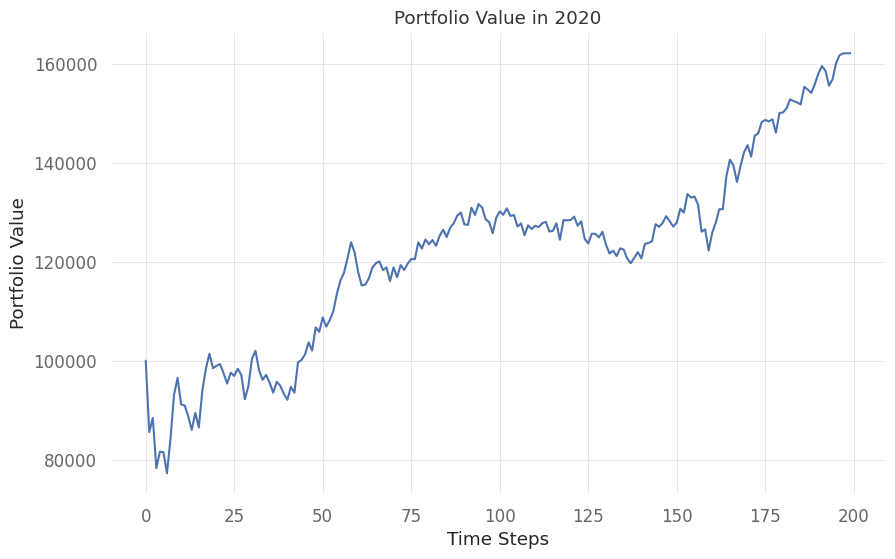

In [74]:
env_2020 = PortfolioOptimizationEnv(
    df_2020,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=features,
    normalize_df=None,
)

results_2020 = test_agent_manual(env_2020, model)
print(f"Final portfolio value after call: {results_2020[-1]}")
plot_portfolio_value(results_2020, "Portfolio Value in 2020")


回測過程中同時紀錄每日的投資組合權重，最後還會繪製權重隨時間變化的圖表，模型對每支股票的配置變化。

Initial portfolio value:100000
Final portfolio value: 162109.0625
Final accumulative portfolio value: 1.6210906505584717
Maximum DrawDown: -0.2274396875
Sharpe ratio: 1.6800460405412


Final portfolio value: 162109.0625


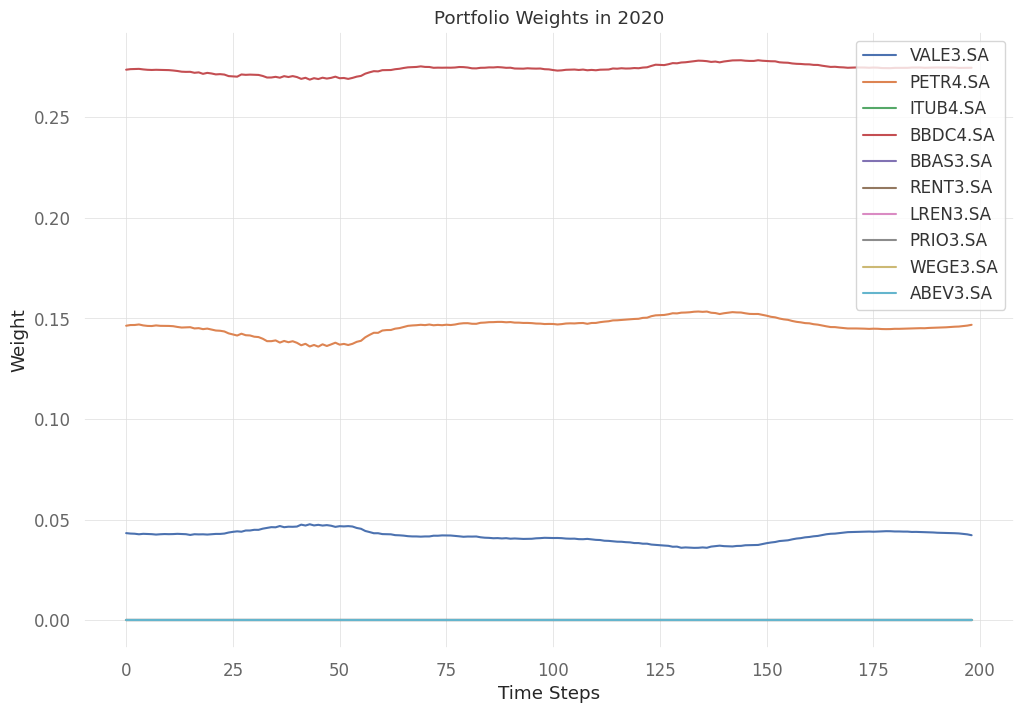

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# 這個函數用來回測並紀錄每日投資組合的權重
def test_agent_with_weights(env, model):
    obs = env.reset()
    done = False

    try:
        initial_amount = env._initial_amount
    except Exception:
        initial_amount = 100000

    account_memory = [initial_amount]
    weights_memory = []  # 用來紀錄每日權重

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        weights_memory.append(action)  # 紀錄當前的投資組合權重
        obs, reward, done, info = env.step(action)

        total_asset = getattr(env, '_portfolio_value', None)
        if total_asset is None:
            try:
                amount = env.amount
                price_ary = env.price_ary
                day = env.day
                stocks = env.stocks
                total_asset = amount + (price_ary[day] * stocks).sum()
            except Exception:
                total_asset = account_memory[-1]
        account_memory.append(total_asset)

    weights_memory = np.array(weights_memory)
    print(f"Final portfolio value: {account_memory[-1]}")
    return account_memory, weights_memory

# 繪製投資組合權重變化圖
def plot_weights(weights, ticker_list, title="Portfolio Weights Over Time"):
    plt.figure(figsize=(12, 8))
    for i, ticker in enumerate(ticker_list):
        plt.plot(weights[:, i], label=ticker)
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Weight")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# 假設你已經有了模型的測試結果，例如 results_2020 和 weights_2020
# ticker_list 是你使用的股票代碼列表
ticker_list = [
    "VALE3.SA", "PETR4.SA",
    "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA",
    "RENT3.SA", "LREN3.SA",
    "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]


results_2020, weights_2020 = test_agent_with_weights(env_2020, model)

# 繪製權重隨時間的變化
plot_weights(weights_2020, ticker_list, "Portfolio Weights in 2020")



In [63]:
import matplotlib.pyplot as plt
import numpy as np
# 假設你已經有了模型的測試結果，例如 results_2020 和 weights_2020
# ticker_list 是你使用的股票代碼列表
ticker_list = [
    "VALE3.SA", "PETR4.SA",
    "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA",
    #"RENT3.SA", "LREN3.SA",
    #"PRIO3.SA",
    #"WEGE3.SA", "ABEV3.SA"
]
def plot_weights(weights, ticker_list, title="Portfolio Weights", step=10, x_max=50):
    T = weights.shape[0]
    plt.figure(figsize=(12, 8))
    for i, t in enumerate(ticker_list):
        plt.plot(weights[:, i], label=t)

    # 只显示 0 到 x_max 的范围
    plt.xlim(0, x_max)
    # 依然可以每 step 个刻度打一个标签
    xticks = np.arange(0, x_max+1, step)
    plt.xticks(xticks, xticks, rotation=45)

    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Weight")
    plt.legend(loc='upper right', bbox_to_anchor=(1.15,1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


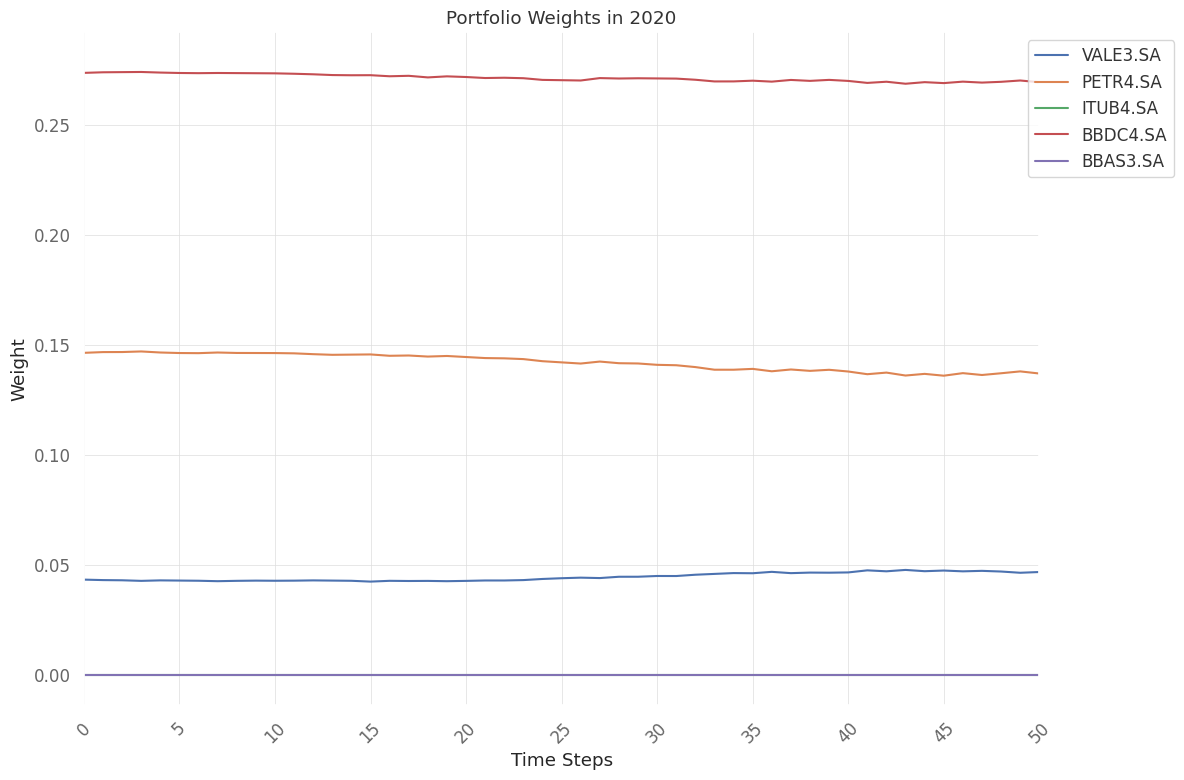

In [64]:
plot_weights(weights_2020, ticker_list, "Portfolio Weights in 2020", step=5, x_max=50)